
(julia.exe:1400): GLib-GIO-WARNING **: 22:47:35.457: Unexpectedly, UWP app `AcerIncorporated.PredatorSenseV30_3.0.3146.0_x64__48frkmn4z8aw4' (AUMId `AcerIncorporated.PredatorSenseV30_48frkmn4z8aw4!CentenialConvert') supports 1 extensions but has no verbs


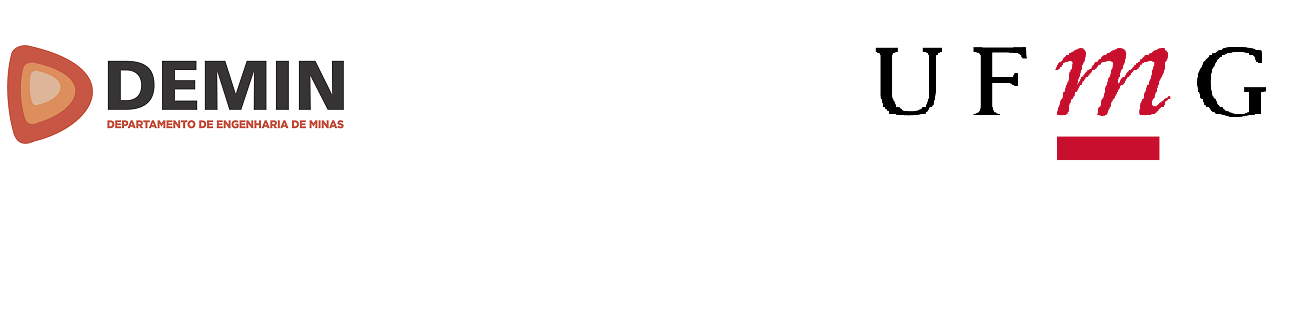

In [1]:
using ImageView, Images
img = load("cabecalho.png")

<h1><center>Mine Planning Optimization <br>UPIT - Marvin Dataset - Python 3.7</center></h1>

> **Advisor**: Douglas Mazzinghy

> **Students**: <br>
Augusto Yuri Cordeiro Santos  
Fernanda Oliveira Marques  
Hayder Matos Batista Sobrinho  


### Firstly, we are importing all modules used in this notebook.

In [2]:
using CSV, DataFrames
using PlotlyJS
using JuMP, Cbc
using Gurobi

WebIO._IJuliaInit()

### After that, we're importing the dataset. In order for the notebook  to work properly, all files must be in the same folder.

In [3]:
dataset = DataFrame(CSV.File("dataset_marvin_UPIT.csv"))

,id,x,y,z,tonn,au [ppm],cu %,proc_profit
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,0,0,0,0,61200.0,0.0,0.0,-4.0
2,1,0,0,1,61200.0,0.0,0.0,-4.0
3,2,0,0,2,61200.0,0.0,0.0,-4.0
4,3,0,0,3,61200.0,0.0,0.0,-4.0
5,4,0,0,4,61200.0,0.0,0.0,-4.0
6,5,0,0,5,61200.0,0.0,0.0,-4.0
7,6,0,0,6,61200.0,0.0,0.0,-4.0
8,7,0,0,7,61200.0,0.0,0.0,-4.0
9,8,0,0,8,61200.0,0.0,0.0,-4.0


### Here, we're storing all of the dataset information in variables of type <em> list </em>.

In [4]:
block_id = dataset[!, 1]
x_coord = dataset[!, 2]
y_coord = dataset[!, 3]
z_coord = dataset[!, 4]
tonn = dataset[!, 5]
value = dataset[!, 8]
# Adjusting for Julia in case the dataset starts from '0'
if block_id[1] == 0
    block_id = [i+1 for i in block_id]
    x_coord = [i+1 for i in x_coord]
    y_coord = [i+1 for i in y_coord]
    z_coord = [i+1 for i in z_coord]
end
dataset_size = length(block_id)
x_axis = range(minimum(x_coord), maximum(x_coord))
y_axis = range(minimum(y_coord), maximum(y_coord))
z_axis = range(minimum(z_coord), maximum(z_coord))
x_length = length(x_axis)
y_length = length(y_axis)
z_length = length(z_axis)

17

## Model, Variables and Objective
#### In this cell, we're creating the optimization model with the Python-MIP package. For this model, we've chosen the CBC solver and established the optimization objetive as maximize, once we're looking for the highest profit in the determined conditions.

In [5]:
mine = Model(Gurobi.Optimizer)
@variable(mine, var_mine[1:dataset_size], Bin)
@variable(mine, var_plant[1:dataset_size], Bin)
@objective(mine, Max, sum(
        var_plant[i] * tonn[i] * value[i] - 0.9 * tonn[i] * var_mine[i] for i in block_id
            ))
time_0 = time()
position = [[[0 for i in x_axis] for i in y_axis] for i in z_axis]
for i in block_id
    position[z_coord[i]][y_coord[i]][x_coord[i]] = i
end
(time()- time_0)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-05-25


0.32399988174438477

## Setting the constraints
#### For a block to be removed all the blocks forming a 45 degree slope above it have to be removed as well.

In [6]:
@constraint(mine, var_mine .>= var_plant)
time_s = time()
function search_45(below)
    restrictions_list = [
        [0,0,1], [-1,0,1], [0,-1,1], [0,1,1], [1,0,1], 
        [-2,-2,3], [-2,2,3], [2,-2,3], [2,2,3], 
        [4,-3,5], [-4,3,5], [-3,-4,5], [-3,4,5], [3,-4,5], [3,4,5], [4,-3,5], [4,3,5]
    ]
    below_x = x_coord[below]
    below_y = y_coord[below]
    below_z = z_coord[below]
    for r_ in restrictions_list
        
        ###
        if below_x + r_[1] >= 1 && below_x + r_[1] <= x_length
            if below_y + r_[2] >= 1 && below_y + r_[2] <= y_length
                if below_z + r_[3] >= 1 && below_z + r_[3] <= z_length
                    above_x = below_x + r_[1]
                    above_y = below_y + r_[2]
                    above_z = below_z + r_[3]
                    above = position[above_z][above_y][above_x]
                    
                    #
                    if above != 0
                        @constraint(mine, var_mine[below] - var_mine[above] <= 0)
                    end
                    #
                    
                end
            end
        end
        ###
        
    end
end
for i in block_id
    search_45(i)
end
(time()-time_s)

1.9399998188018799

## Running the model and returning the results

##### It's worth noting that our results were slightly different from minelib's outcomes. This happened because, in our optimizator, it's utilized a direct precedence rule between the blocks, where a block can only be removed if the 9 or 5 blocks above it are removed as well. Therefore, we're making sure that the slope has, at maximum, 45° inclination in x-y axis in the case of the most conservative, 9 block precedence. However, in the diagonals, the max slope angle has, approximately, 35°. This angle ensures the safety boundaries of the pit, but does not harness the pit's max potential. <br>
##### Meanwhile, the website's precedence method envolves surface evaluation, which requires a consideratively more complex elaboration compared to what we've used; the exact value, given by 1,415,655,436, represents a relatively low difference from the 1,364,462,123 result in the 9 precedence model: 4%.
##### For the 5 block precedence, which doesn't guarantee the maximum 45º slope, we have an estimated return of 1,442,963,479, about 2% higher than the minelib’s estimate. 
##### As a curiosity, those two average out at 99,2% precision, one being overshot and the other being undershot.

In [7]:
time_1 = time()
optimize!(mine)
(time()-time_1)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 703919 rows, 106542 columns and 1407838 nonzeros
Model fingerprint: 0x7eb44716
Variable types: 0 continuous, 106542 integer (106542 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 621978 rows and 98086 columns (presolve time = 5s) ...
Presolve removed 646070 rows and 99804 columns
Presolve time: 7.52s
Presolved: 57849 rows, 6738 columns, 115698 nonzeros
Found heuristic solution: objective 6.272075e+08
Variable types: 0 continuous, 6738 integer (6738 binary)
Found heuristic solution: objective 6.421949e+08

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0741023e+08   1.006358e+09   0.000000e+00      8s


13.3989999294281

In [8]:
@show objective_value(mine)

objective_value(mine) = 1.4165776138734553e9


1.4165776138734553e9

In [9]:
mined_id = []
processed_id = []
for i in block_id
    if JuMP.value.(var_mine[i]) >= 1
        append!(mined_id, block_id[i])
        if JuMP.value.(var_plant[i]) >= 1
            append!(processed_id, block_id[i])
        end
    end
end

x_mined = [x_coord[i] for i in mined_id]
y_mined = [y_coord[i] for i in mined_id]
z_mined = [z_coord[i] for i in mined_id]

mined = 

x_processed = [x_coord[i] for i in processed_id]
y_processed = [y_coord[i] for i in processed_id]
z_processed = [z_coord[i] for i in processed_id]

color_mined = [1 for i in mined_id]
color_processed = [1 for i in processed_id]
total_mined = (length(mined_id))
total_processed = (length(processed_id))

4341

## Open pit design

In [10]:
## Processed blocksplot(scatter(x = x_mined, y = y_mined, z = z_mined, mode = "markers", marker = attr(
            size = 5,
            color = color_mined,
            colorscale="blackbody",
            opacity = 0.7),
        type = "scatter3d"))

data: [
  "scatter3d with fields marker, mode, type, x, y, and z"
]

layout: "layout with fields margin and template"

## Processed blocks

In [12]:
plot(scatter(x = x_processed, y = y_processed, z = z_processed, mode = "markers", marker = attr(
            size = 5,
            color = color_processed,
            colorscale="viridis",
            opacity = 0.4),
        type = "scatter3d"))

data: [
  "scatter3d with fields marker, mode, type, x, y, and z"
]

layout: "layout with fields margin and template"

In [13]:
blocos_usina = []
for i in 1:dataset_size
    if JuMP.value.(var_plant[i]) > 0
        append!(blocos_usina, i)
    end
end
blocos_usina

4341-element Vector{Any}:
 11937
 11952
 11953
 11966
 11967
 11968
 12827
 12828
 12842
 12843
 12844
 12845
 12856
     ⋮
 31216
 31217
 31229
 31230
 31231
 31414
 31415
 31429
 31430
 31444
 31445
 32044